In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
USE_GPU = False

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [4]:
class DropDataset(Dataset):
    """Droplet dataset."""

    def __init__(self, npz_filename, root_dir="", transform=None):
        """
        Args:
            npz_filename (string): Path to the npz file with data.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        x = None
        y = None
        self.new_feat = None

        with np.load(npz_filename) as data:
            x = data['ims']
            y = data['classes']
            self.new_feat = data['f']
        x = x.astype(np.float32)
        y = y.astype(np.float32)
        #shuffle datasets
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]
        self.x = torch.from_numpy(x).unsqueeze_(1)
        self.y = torch.from_numpy(y)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.x[idx]
        label = self.y[idx]
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
NUM_TRAIN = 16000

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
drop_set = DropDataset('np_data_3_balanced.npz')

print("loaded dataset")

loader_train = DataLoader(drop_set, batch_size=128, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(drop_set, batch_size=128, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 18000)))

print("split dataset")

print(torch.__version__)

loaded dataset
split dataset
0.4.0


In [6]:
def check_accuracy_part34(loader, model):
#     if loader.dataset.train:
#         print('Checking accuracy on validation set')
#     else:
#         print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for sample in loader:
            # sample form: {'image': image, 'label': label}
            x = sample['image']
            y = sample['label']
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            _, scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [7]:
def display_images(loader, model):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, samplev in enumerate(loader):
            # sample form: {'image': image, 'label': label}
            x = samplev['image']
          
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = x
            x,_ = model(x)
            
            y = y.data.numpy()
            im=x.data.numpy()
            for i in range(5):
                a = im[i]
                b = y[i]
                a = a.reshape((210,210))
                b = b.reshape((210,210))
                print("Recon")
                plt.imshow(a,cmap='gray')
                plt.colorbar()
                plt.show()
                print("Orig")                
                plt.imshow(b,cmap='gray')
                plt.show()
            return
            
            if(t>0):
                return


In [8]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on Drop dataset using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    losses = []
    re_loss = []
    pred_loss = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, sample in enumerate(loader_train):
            model.train()  # put model to training mode
            x = sample['image']
            y = sample['label']
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            

            recon, scores = model(x)
            
            loss_pred = F.cross_entropy(scores, y)
            
            loss_cons = F.mse_loss(recon,x)
            
            loss = loss_pred #loss_cons  + loss_pred/1000.0
            
            pred_loss.append(loss_pred)
            re_loss.append(loss_cons)
            losses.append(loss)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % print_every == 0:
                print("Epoch {}".format(e)) 
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                #display_images(loader_train, model)


    print("Total Loss")            
    plt.plot(losses)
    plt.show()
    print("Recon Loss")            
    plt.plot(re_loss)
    plt.show()
    print("Prediction Loss")            
    plt.plot(pred_loss)
    plt.show()

In [9]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1), x.shape  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

# test_flatten()

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)


def unflatten(x,size):
#     N = x.shape[0] # read in N, C, H, W
    
    return x.view(size)  # "flatten" the C * H * W values into a single vector per image

# def test_unflatten():
#     x = torch.arange(16).view(16, 1)
#     print('\n\nBefore unflattening: ', x)
#     print('After unflattening: ', unflatten(x,8))

# test_unflatten()

In [10]:
class Unflatten(nn.Module):
    def forward(self, x,size):
        return unflatten(x,size)

In [11]:
#autoencoder time!

class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 4, 6, stride=4, padding=24)  
        self.r1 = nn.Tanh()
        self.p1 = nn.MaxPool2d(2,return_indices=True)        
        self.c2 = nn.Conv2d(4, 1, 17, stride=1, padding=0) 
        self.r2 = nn.Tanh()
        self.p2 = nn.MaxPool2d(2,return_indices=True) 
        self.c3 = nn.Conv2d(1, 1, 7, stride=1, padding=1) 
        self.r3 = nn.Tanh()
        self.c4 = nn.Conv2d(1, 1, 3, stride=1, padding=0) 
        self.r4 = nn.Tanh()
        self.fc1 = nn.Linear(4*4, 3)
        self.fc2 = nn.Linear(3, 4*4)
#         self.r4 = nn.ReLU(True)
        self.uc4 = nn.ConvTranspose2d(1, 1, 3, stride=1, padding=0) 
        self.uc3 = nn.ConvTranspose2d(1, 1, 7, stride=1, padding=1) 
        self.u2 = nn.MaxUnpool2d(2)
        self.r5 = nn.Tanh()
        self.uc2 = nn.ConvTranspose2d(1, 4, 17, stride=1, padding=0) 
        self.r6 = nn.Tanh()
        self.u1 = nn.MaxUnpool2d(2)
        self.r7 = nn.Tanh()
        self.uc1 = nn.ConvTranspose2d(4, 1, 6, stride=4, padding=24)   
        self.t1 = nn.Tanh()
        
        
        self.L1 = nn.Linear(4,2) #change based on size of code
        self.f1 = Flatten()
        nn.init.kaiming_normal_(self.L1.weight)
        
        nn.init.xavier_normal_(self.c1.weight)
        nn.init.xavier_normal_(self.c2.weight)
        nn.init.xavier_normal_(self.c3.weight)
        nn.init.xavier_normal_(self.c4.weight)
        
        nn.init.xavier_normal_(self.uc1.weight)
        nn.init.xavier_normal_(self.uc2.weight)
        nn.init.xavier_normal_(self.uc3.weight)
        nn.init.xavier_normal_(self.uc4.weight)

    def forward(self, x):
        c, ind, ind2 =  self.encode(x)
        y = self.decode(c, ind, ind2)
        scores = self.predict(c)
        return y, scores

    def encode(self,x):
        #         print(x.size())
        x = self.c1(x)
        x = self.r1(x)
        x,ind = self.p1(x)
        x = self.c2(x)
        x = self.r2(x)
        x,ind2 = self.p2(x)
#         print(x.size())
        x = self.c3(x)
#         print(x.size())
        x = self.r3(x)
        x = self.c4(x)
        c = self.r4(x)
        return c, ind, ind2
        
    def decode(self,c,ind,ind2):
        y = self.uc4(c)
        y = self.uc3(y)
        y = self.u2(y,ind2)
        y = self.r5(y)
        y = self.uc2(y)
        y = self.r6(y)
        y = self.u1(y,ind)
        y = self.r7(y)
        y = self.uc1(y)
        y = self.t1(y)
#         print(y.size())
        return y

    def predict(self,c):
            p = self.f1(c)
            p = self.L1(p)
            return p

In [12]:
class no_pool_autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 1, 5, stride=3, padding=4) #210->72
        self.c2 = nn.Conv2d(1, 1, 5, stride=3, padding=4) #72->26
        self.c3 = nn.Conv2d(1, 1, 4, stride=2, padding=4) #26->16
        self.c4 = nn.Conv2d(1, 1, 4, stride=2, padding=1) #16->8
        
        self.c5 = nn.Conv2d(1, 1, 4, stride=2, padding=1) #8->4
        self.c6 = nn.Conv2d(1, 1, 2, stride=2, padding=0) #4->2
        
        self.uc1 = nn.ConvTranspose2d(1, 1, 5, stride=3, padding=4) #72->
        self.uc2 = nn.ConvTranspose2d(1, 1, 5, stride=3, padding=4) #26->72
        self.uc3 = nn.ConvTranspose2d(1, 1 , 4, stride=2, padding=4) #16->26
        self.uc4 = nn.ConvTranspose2d(1, 1, 4, stride=2, padding=1) #8->16
        
        self.uc5 = nn.ConvTranspose2d(1, 1, 4, stride=2, padding=1) #4->8
        self.uc6 = nn.ConvTranspose2d(1, 1, 2, stride=2, padding=0) #2->4
        
        self.t1 = nn.ReLU()
        self.t2 = nn.ReLU()
        self.t3 = nn.ReLU()
        self.t4 = nn.Tanh()
        self.t5 = nn.Tanh()
        self.t6 = nn.Tanh()
        
        self.ut1 = nn.ReLU()
        self.ut2 = nn.ReLU()
        self.ut3 = nn.ReLU()
        self.ut4 = nn.Tanh()
        self.ut5 = nn.Tanh()
        self.ut6 = nn.Tanh()
        
        self.L1 = nn.Linear(32,2) #change based on size of code
        self.f1 = Flatten()
        nn.init.kaiming_normal_(self.L1.weight)
        
        self.Li = nn.Linear(26*26,32) #change based on size of code
        self.fi = Flatten()
        nn.init.kaiming_normal_(self.Li.weight)
        
#         self.Li2 = nn.Linear(64,32) #change based on size of code
#         nn.init.kaiming_normal_(self.Li2.weight)
        
        self.Lo = nn.Linear(32,26*26) #change based on size of code
        self.fo = Unflatten()
        nn.init.kaiming_normal_(self.Lo.weight)
        
#         self.Lo2 = nn.Linear(32,64) #change based on size of code
#         nn.init.kaiming_normal_(self.Lo2.weight)
        
        
        nn.init.kaiming_normal_(self.c1.weight)
        nn.init.kaiming_normal_(self.c2.weight)
        nn.init.kaiming_normal_(self.c3.weight)
        nn.init.kaiming_normal_(self.c4.weight)
        nn.init.kaiming_normal_(self.c5.weight)
        nn.init.kaiming_normal_(self.c6.weight)
        
        nn.init.kaiming_normal_(self.uc1.weight)
        nn.init.kaiming_normal_(self.uc2.weight)
        nn.init.kaiming_normal_(self.uc3.weight)
        nn.init.kaiming_normal_(self.uc4.weight)
        nn.init.kaiming_normal_(self.uc5.weight)
        nn.init.kaiming_normal_(self.uc6.weight)
        
        

    def forward(self, x):
        c,size =  self.encode(x)
        y = self.decode(c,size)
        scores = self.predict(c)
        return y, scores

    def encode(self,x):
        c = self.c1(x)
        c = self.t1(c)
        
        c = self.c2(c)
        c = self.t2(c)
        c,size = self.fi(c)
        
        c = self.Li(c)
        c = self.t3(c)
        
#         c = self.Li2(c)
#         c = self.t4(c) 
        
#         c = self.c3(c)
#         c = self.t3(c)
        
#         c = self.c4(c)
#         c = self.t4(c)
        
#         c = self.c5(c)
#         c = self.t5(c)
        
#         c = self.c6(c)
#         c = self.t6(c)
        return c, size
    
    def decode(self,c,size):
#         y = self.uc6(c)
#         y = self.ut6(y)
        
#         y = self.uc5(y)
#         y = self.ut5(y)
        
#         y = self.uc4(c)
#         y = self.ut4(y)
        
#         y = self.uc3(y)
#         y = self.ut3(y)
        
#         y = self.Lo2(c)
#         y = self.ut4(y)
        
        y = self.Lo(c)
        y = self.ut3(y)
        y = self.fo(y,size)
        y = self.uc2(y)
        y = self.ut2(y)
        
        y = self.uc1(y)
        y = self.ut1(y)
        return y
    
    def predict(self,c):
        p = self.f1(c)[0]
        p = self.L1(p)
        return p

In [13]:
class autoencoder_jk(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 16, 6, stride=4, padding=24) #b,16,64,64 
        self.r1 = nn.Tanh()
        self.p1 = nn.MaxPool2d(2,return_indices=False)        #b,16,32,32
        self.c2 = nn.Conv2d(16, 8, 4, stride=2, padding=1) #b,8,16,16
        self.r2 = nn.Tanh()
        self.p2 = nn.MaxPool2d(2,return_indices=False) #b,8,8,8
        self.c3 = nn.Conv2d(8, 4, 4, stride=2, padding=1) #b,4,4,4
        self.r8 = nn.Tanh()
        self.c4 = nn.Conv2d(4, 2, 3, stride=1, padding=0) #b,2,2,2
        self.r10 = nn.Tanh()
        self.c5 = nn.Conv2d(2, 2, 2, stride=1, padding=0) #b,2,1,1
        self.r12 = nn.Tanh()

#         self.r4 = nn.ReLU(True)
        self.uc9 = nn.ConvTranspose2d(2, 2, 2, stride=1, padding=0) #b,2,2,2
        self.r13 = nn.Tanh()
        self.uc8 = nn.ConvTranspose2d(2, 4, 3, stride=1, padding=0) #b,4,4,4
        self.r11 = nn.Tanh()
        self.uc7 = nn.ConvTranspose2d(4, 8, 5, stride=1, padding=0) #b,8,8,8
        self.r9 = nn.Tanh()
        self.uc1 = nn.ConvTranspose2d(8, 16, 5, stride=1, padding=0) #b,16,12,12
        self.r3 = nn.Tanh()
        self.uc2 = nn.ConvTranspose2d(16, 16, 5, stride=1, padding=0) #b,16,16,16
        self.r4 = nn.Tanh()
        self.uc3 = nn.ConvTranspose2d(16, 8, 5, stride=3, padding=0)  #b,8,50,50
        self.r5 = nn.Tanh()
        self.uc4 = nn.ConvTranspose2d(8, 4, 5, stride=2, padding=0)   #b,4,103,103
        self.uc5 = nn.ConvTranspose2d(4, 1, 5, stride=2, padding=0)   #b,1,209,209
        self.uc6 = nn.ConvTranspose2d(1, 1, 2, stride=1, padding=0)   #b,1,210,210
#         self.fc1 = nn.Linear(209*209,210*210)
        self.r6 = nn.Tanh()
#         self.fc2 = nn.Linear(210*210*2,210*210)
        self.r7 = nn.Tanh()
        self.t1 = nn.Tanh()
        
        
        nn.init.kaiming_normal_(self.c1.weight)
        nn.init.kaiming_normal_(self.c2.weight)
        nn.init.kaiming_normal_(self.c3.weight)
        nn.init.kaiming_normal_(self.c4.weight)
#         nn.init.xavier_normal_(self.c5.weight)
        
        nn.init.kaiming_normal_(self.uc1.weight)
        nn.init.kaiming_normal_(self.uc2.weight)
        nn.init.kaiming_normal_(self.uc3.weight)
        nn.init.kaiming_normal_(self.uc4.weight)
        nn.init.kaiming_normal_(self.uc5.weight)
        nn.init.kaiming_normal_(self.uc6.weight)
        nn.init.kaiming_normal_(self.uc7.weight)
        nn.init.kaiming_normal_(self.uc8.weight)
#         nn.init.xavier_normal_(self.uc9.weight)

        self.L1 = nn.Linear(8,2) #change based on size of code
        self.f1 = Flatten()
        nn.init.kaiming_normal_(self.L1.weight)

    def forward(self, x):
        c, ind, ind2 =  self.encode(x)
#         print(c.shape)
        y = self.decode(c, ind, ind2)
        scores = self.predict(c)
        return y, scores

    def encode(self,x):
        #         print(x.size())
        x = self.c1(x)
        x = self.r1(x)
        x = self.p1(x)
        x = self.c2(x)
        x = self.r2(x)
        x = self.p2(x)
        x = self.c3(x)
        x = self.r8(x)
        x = self.c4(x)
        c = self.r10(x)
#         x = self.c5(x)
#         c = self.r12(x)
#         print(x.size())
#         x = self.c3(x)
#         print(x.size())
#         x = self.r3(x)
#         x = self.c4(x)
#         c = self.r4(x)
        ind = None
        ind2 = None
        return c, ind, ind2
        
    def decode(self,c,ind,ind2):
#         y = self.uc9(c)
#         y = self.r13(y)
        y = self.uc8(c)
        y = self.r11(y)
        y = self.uc7(y)
        y = self.r9(y)
        y = self.uc1(y)
        y = self.r3(y)
        y = self.uc2(y)
        y = self.r4(y)
        y = self.uc3(y)
        y = self.r5(y)
        y = self.uc4(y)
        y = self.r6(y)
        y = self.uc5(y)
        y = self.r7(y)
        y = self.uc6(y)
#         y = flatten(y)
#         y = self.fc1(y)
        
#         y = self.fc2(y)
#         y = self.r7(y)
#         y = unflatten(y,210)
        y = self.t1(y)
#         print(y.size())
        return y

    def predict(self,c):
        p = self.f1(c)[0]
        p = self.L1(p)
        return p
        

In [14]:
class autoencoder_jk_2f(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 16, 6, stride=4, padding=24) #b,16,64,64 
        self.r1 = nn.Tanh()
        self.p1 = nn.MaxPool2d(2,return_indices=False)        #b,16,32,32
        self.c2 = nn.Conv2d(16, 8, 4, stride=2, padding=1) #b,8,16,16
        self.r2 = nn.Tanh()
        self.p2 = nn.MaxPool2d(2,return_indices=False) #b,8,8,8
        self.c3 = nn.Conv2d(8, 4, 4, stride=2, padding=1) #b,4,4,4
        self.r8 = nn.Tanh()
        self.c4 = nn.Conv2d(4, 2, 3, stride=1, padding=0) #b,2,2,2
        self.r10 = nn.Tanh()
        self.c5 = nn.Conv2d(2, 2, 2, stride=1, padding=0) #b,2,1,1
        self.r12 = nn.Tanh()

#         self.r4 = nn.ReLU(True)
        self.uc9 = nn.ConvTranspose2d(2, 2, 2, stride=1, padding=0) #b,2,2,2
        self.r13 = nn.Tanh()
        self.uc8 = nn.ConvTranspose2d(2, 4, 3, stride=1, padding=0) #b,4,4,4
        self.r11 = nn.Tanh()
        self.uc7 = nn.ConvTranspose2d(4, 8, 5, stride=1, padding=0) #b,8,8,8
        self.r9 = nn.Tanh()
        self.uc1 = nn.ConvTranspose2d(8, 16, 5, stride=1, padding=0) #b,16,12,12
        self.r3 = nn.Tanh()
        self.uc2 = nn.ConvTranspose2d(16, 16, 5, stride=1, padding=0) #b,16,16,16
        self.r4 = nn.Tanh()
        self.uc3 = nn.ConvTranspose2d(16, 8, 5, stride=3, padding=0)  #b,8,50,50
        self.r5 = nn.Tanh()
        self.uc4 = nn.ConvTranspose2d(8, 4, 5, stride=2, padding=0)   #b,4,103,103
        self.uc5 = nn.ConvTranspose2d(4, 1, 5, stride=2, padding=0)   #b,1,209,209
        self.uc6 = nn.ConvTranspose2d(1, 1, 2, stride=1, padding=0)   #b,1,210,210
#         self.fc1 = nn.Linear(209*209,210*210)
        self.r6 = nn.Tanh()
#         self.fc2 = nn.Linear(210*210*2,210*210)
        self.r7 = nn.Tanh()
        self.t1 = nn.Tanh()
        
        
        nn.init.kaiming_normal_(self.c1.weight)
        nn.init.kaiming_normal_(self.c2.weight)
        nn.init.kaiming_normal_(self.c3.weight)
        nn.init.kaiming_normal_(self.c4.weight)
#         nn.init.xavier_normal_(self.c5.weight)
        
        nn.init.kaiming_normal_(self.uc1.weight)
        nn.init.kaiming_normal_(self.uc2.weight)
        nn.init.kaiming_normal_(self.uc3.weight)
        nn.init.kaiming_normal_(self.uc4.weight)
        nn.init.kaiming_normal_(self.uc5.weight)
        nn.init.kaiming_normal_(self.uc6.weight)
        nn.init.kaiming_normal_(self.uc7.weight)
        nn.init.kaiming_normal_(self.uc8.weight)
#         nn.init.xavier_normal_(self.uc9.weight)

        self.L1 = nn.Linear(8,32) #change based on size of code
        self.f1 = Flatten()
        nn.init.kaiming_normal_(self.L1.weight)
        
        self.R1 = nn.ReLU()
        
        self.L2 = nn.Linear(32,2) #change based on size of code
        nn.init.kaiming_normal_(self.L2.weight)
        
        self.R2 = nn.ReLU()

    def forward(self, x):
        c, ind, ind2 =  self.encode(x)
#         print(c.shape)
        y = self.decode(c, ind, ind2)
        scores = self.predict(c)
        return y, scores

    def encode(self,x):
        #         print(x.size())
        x = self.c1(x)
        x = self.r1(x)
        x = self.p1(x)
        x = self.c2(x)
        x = self.r2(x)
        x = self.p2(x)
        x = self.c3(x)
        x = self.r8(x)
        x = self.c4(x)
        c = self.r10(x)
#         x = self.c5(x)
#         c = self.r12(x)
#         print(x.size())
#         x = self.c3(x)
#         print(x.size())
#         x = self.r3(x)
#         x = self.c4(x)
#         c = self.r4(x)
        ind = None
        ind2 = None
        return c, ind, ind2
        
    def decode(self,c,ind,ind2):
#         y = self.uc9(c)
#         y = self.r13(y)
        y = self.uc8(c)
        y = self.r11(y)
        y = self.uc7(y)
        y = self.r9(y)
        y = self.uc1(y)
        y = self.r3(y)
        y = self.uc2(y)
        y = self.r4(y)
        y = self.uc3(y)
        y = self.r5(y)
        y = self.uc4(y)
        y = self.r6(y)
        y = self.uc5(y)
        y = self.r7(y)
        y = self.uc6(y)
#         y = flatten(y)
#         y = self.fc1(y)
        
#         y = self.fc2(y)
#         y = self.r7(y)
#         y = unflatten(y,210)
        y = self.t1(y)
#         print(y.size())
        return y

    def predict(self,c):
        p = self.f1(c)[0]
        p = self.L1(p)
        p = self.R1(p)
        p = self.L2(p)
        p = self.R2(p)
        return p
        

In [15]:
def conv_out(h_in, filt,stride,padding):
    return (h_in+2*padding-(filt-1)-1)/stride + 1

In [16]:
def conv_t_out(h_in,filt,stride,padding):
    return (h_in-1)*stride - 2*padding + filt

In [ ]:
model_6 = autoencoder_jk_2f()
optimizer_3 = torch.optim.Adam(model_6.parameters(),lr=0.001)
train_part34(model_6, optimizer_3,60)
torch.save(model_6.state_dict(), '8_code_2c_pred_train_60_total')

Epoch 0
Iteration 0, loss = 0.6884
Got 1116 / 2000 correct (55.80)
Epoch 0
Iteration 100, loss = 0.6774
Got 1237 / 2000 correct (61.85)
Epoch 1
Iteration 0, loss = 0.5486
Got 1235 / 2000 correct (61.75)
Epoch 1
Iteration 100, loss = 0.5813
Got 1260 / 2000 correct (63.00)
Epoch 2
Iteration 0, loss = 0.5650
Got 1314 / 2000 correct (65.70)


In [37]:
def visualize_feature(feature_ind, model,ims,feature_sds):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        feature_sds = feature_sds.view(-1)
        for im in ims:
            print("New Test")
            im = im.to(device=device, dtype=dtype)
            
            im = im.view((1,1,210,210))
            code,ind,ind2 = model.encode(im)
            size = code.shape
            
            orig = model.decode(code,ind,ind2)    
            orig=orig.data.numpy()
            orig=orig.reshape((210,210))
            print('Original Image, reconstructed')
            plt.imshow(orig,cmap='gray')
            plt.show()
            
            
            code = code.view(-1)
            sd = feature_sds[feature_ind]

            for delta in torch.arange(-sd,sd,sd/2.0):
                pert = code.clone()
                pert[feature_ind] += delta
                pert = pert.view(size)
                out = model.decode(pert,ind,ind2)
                
                out=out.data.numpy()
           
                out=out.reshape((210,210))
                print('Recon, feature = {}, delta = {}'.format(feature_ind, delta))
                plt.imshow(out,cmap='gray')
                plt.show()

In [38]:
def compute_feature_stats(model,loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        codes = []
        for im in loader:
            # sample form: {'image': image, 'label': label}
            x = im['image']
            # y = sample['label']
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            code = model.encode(x)[0].detach()
            codes.append(code)
        codes = torch.cat(codes,dim=0)
        mean = torch.mean(codes,0).detach()
        var = torch.var(codes,0).detach()
    return mean,var

In [39]:
feat_mean, feat_sd = compute_feature_stats(model_3,loader_train)

In [40]:
feat_mean

tensor([[[ 0.3316,  0.6126],
         [ 0.0095, -0.2271]],

        [[-0.1005, -0.1261],
         [-0.1086, -0.2717]]])

In [41]:
feat_sd

tensor([[[ 0.2257,  0.1710],
         [ 0.4465,  0.1898]],

        [[ 0.1868,  0.2352],
         [ 0.1261,  0.1442]]])

In [42]:
ims = [drop_set.__getitem__(10*i)['image'] for i in range(2)]

In [43]:
ims[0].shape

torch.Size([1, 210, 210])

New Test
Original Image, reconstructed


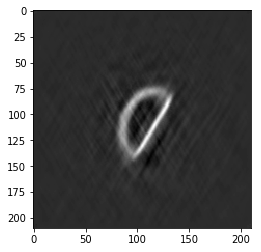

Recon, feature = 0, delta = -2.2568984031677246


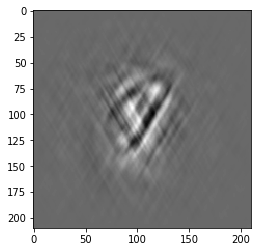

Recon, feature = 0, delta = -1.1284492015838623


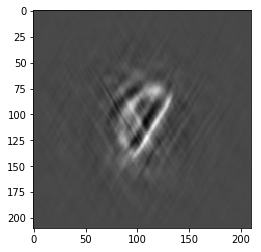

Recon, feature = 0, delta = 0.0


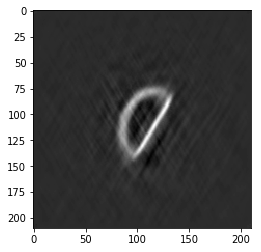

Recon, feature = 0, delta = 1.1284492015838623


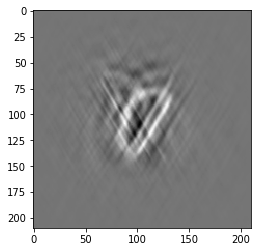

New Test
Original Image, reconstructed


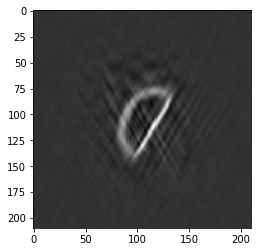

Recon, feature = 0, delta = -2.2568984031677246


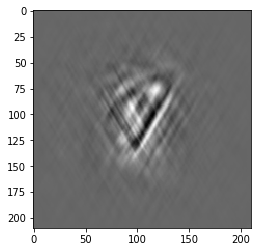

Recon, feature = 0, delta = -1.1284492015838623


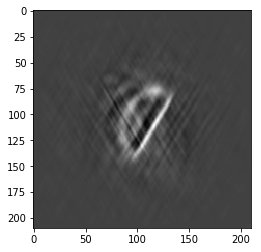

Recon, feature = 0, delta = 0.0


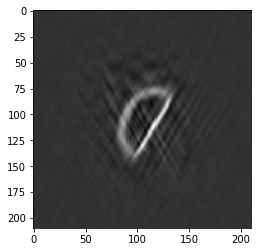

Recon, feature = 0, delta = 1.1284492015838623


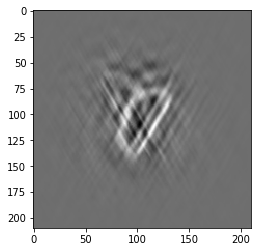

In [44]:
visualize_feature(0, model_3,ims,10.0*feat_sd)

In [70]:
torch.save(model_1.state_dict(), 'tanh_4code')

In [13]:
model_2 = autoencoder()
model_2.load_state_dict(torch.load('tanh_4code'))